<a href="https://colab.research.google.com/github/Manvithtech07/Forest-Fire-Detection-And-Prediction/blob/main/notebooks/feature_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!pip install rasterio

In [16]:
from google.colab import drive
drive.mount('/content/drive')

import rasterio
import numpy as np
import os
import matplotlib.pyplot as plt

# To ignore common warnings
import warnings
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
GDRIVE_PROJECT_PATH = "/content/drive/My Drive/"
PROCESSED_PATH = f"{GDRIVE_PROJECT_PATH}/data/processed"
CLEAN_PATH = f"{PROCESSED_PATH}/clean"
FEATURES_PATH = f"{GDRIVE_PROJECT_PATH}/data/features"
if not os.path.exists(FEATURES_PATH):
    os.makedirs(FEATURES_PATH)
    print(f"Created folder: {FEATURES_PATH}")
else:
    print(f"Features folder exists: {FEATURES_PATH}")

Features folder exists: /content/drive/My Drive//data/features


In [18]:
def save_raster(template_raster_path, target_raster_path, data_array, dtype='float32'):

    if os.path.exists(target_raster_path):
        print(f"File exists,: {os.path.basename(target_raster_path)}")
        return
    try:
        with rasterio.open(template_raster_path) as template_src:
            meta = template_src.meta.copy()

        meta.update({
            'dtype': dtype,
            'nodata': np.nan
        })

        with rasterio.open(target_raster_path, 'w', **meta) as dst:
            dst.write(data_array, 1)
    except Exception as e:
        print(f"ERROR {os.path.basename(target_raster_path)}: {e}\n")

## 1. Calculate Vegetation Index: NDVI

First, we calculate the Normalized Difference Vegetation Index (NDVI) for both our pre-fire and post-fire images. This index is a strong indicator of vegetation health.

**Formula:** `NDVI = (Band 5 - Band 4) / (Band 5 + Band 4)`

In [19]:
pre_b5_filename = "clean_clipped_LC08_L2SP_145040_20210309_20210317_02_T1_SR_B5.TIF"
pre_b4_filename = "clean_clipped_LC08_L2SP_145040_20210309_20210317_02_T1_SR_B4.TIF"

post_b5_filename = "clean_clipped_LC08_L2SP_145040_20210410_20210416_02_T1_SR_B5.TIF"
post_b4_filename = "clean_clipped_LC08_L2SP_145040_20210410_20210416_02_T1_SR_B4.TIF"

pre_b5_path = f"{CLEAN_PATH}/{pre_b5_filename}"
pre_b4_path = f"{CLEAN_PATH}/{pre_b4_filename}"
post_b5_path = f"{CLEAN_PATH}/{post_b5_filename}"
post_b4_path = f"{CLEAN_PATH}/{post_b4_filename}"

with rasterio.open(pre_b5_path) as nir_src, rasterio.open(pre_b4_path) as red_src:
    nir = nir_src.read(1).astype('float32')
    red = red_src.read(1).astype('float32')

    with np.errstate(divide='ignore', invalid='ignore'):
        ndvi_pre = (nir - red) / (nir + red)

    ndvi_pre[np.isnan(nir)] = np.nan

save_raster(
    template_raster_path=pre_b5_path,
    target_raster_path=f"{FEATURES_PATH}/ndvi_pre.tif",
    data_array=ndvi_pre
)

with rasterio.open(post_b5_path) as nir_src, rasterio.open(post_b4_path) as red_src:
    nir = nir_src.read(1).astype('float32')
    red = red_src.read(1).astype('float32')

    with np.errstate(divide='ignore', invalid='ignore'):
        ndvi_post = (nir - red) / (nir + red)

    ndvi_post[np.isnan(nir)] = np.nan

# Save the result
save_raster(
    template_raster_path=post_b5_path,
    target_raster_path=f"{FEATURES_PATH}/ndvi_post.tif",
    data_array=ndvi_post
)


File exists,: ndvi_pre.tif
File exists,: ndvi_post.tif


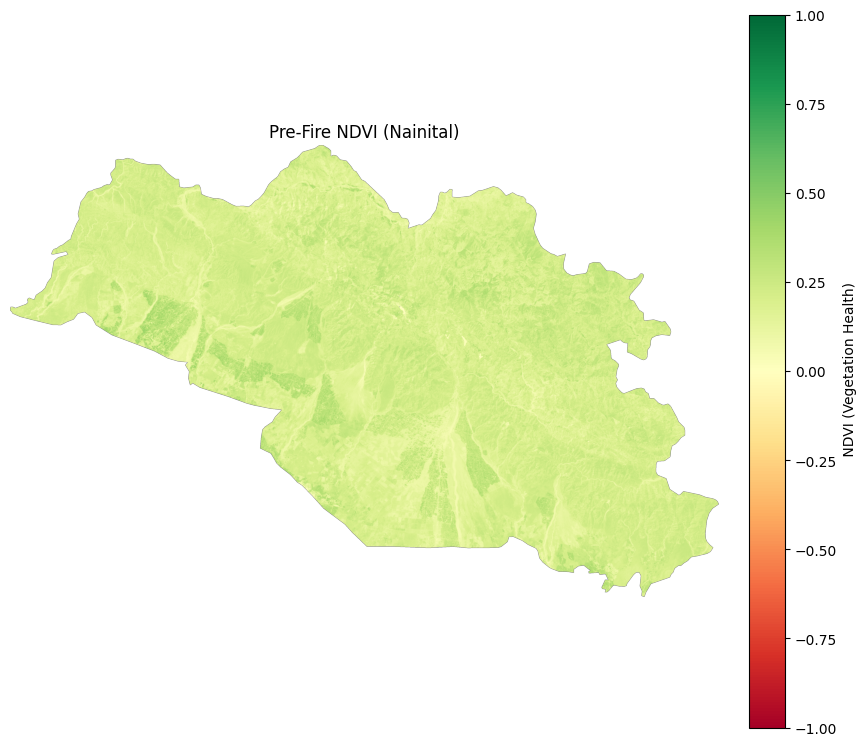

In [20]:
ndvi_pre_path = f"{FEATURES_PATH}/ndvi_pre.tif"
try:
    with rasterio.open(ndvi_pre_path) as src:
        ndvi_pre_data = src.read(1)
        plt.figure(figsize=(10, 10))

        im = plt.imshow(ndvi_pre_data, cmap='RdYlGn', vmin=-1, vmax=1)
        plt.colorbar(im, fraction=0.046, pad=0.04, label=" NDVI (Vegetation Health)")

        plt.title("Pre-Fire NDVI (Nainital)")
        plt.axis('off')
        plt.show()

except Exception as e:
    print(f"ERROR {e}")

## 2. Calculate Burn Index: NBR

Next, we calculate the Normalized Burn Ratio (NBR) for both pre-fire and post-fire. This index is highly effective at identifying burned areas. Healthy vegetation has high NBR, while burned, dry areas have low NBR.

**Formula:** `NBR = (Band 5 - Band 7) / (Band 5 + Band 7)`

In [21]:
pre_b5_filename = "clean_clipped_LC08_L2SP_145040_20210309_20210317_02_T1_SR_B5.TIF"
pre_b7_filename = "clean_clipped_LC08_L2SP_145040_20210309_20210317_02_T1_SR_B7.TIF"

post_b5_filename = "clean_clipped_LC08_L2SP_145040_20210410_20210416_02_T1_SR_B5.TIF"
post_b7_filename = "clean_clipped_LC08_L2SP_145040_20210410_20210416_02_T1_SR_B7.TIF"

pre_b5_path = f"{CLEAN_PATH}/{pre_b5_filename}"
pre_b7_path = f"{CLEAN_PATH}/{pre_b7_filename}"
post_b5_path = f"{CLEAN_PATH}/{post_b5_filename}"
post_b7_path = f"{CLEAN_PATH}/{post_b7_filename}"

#calculating pre-fire NBR
with rasterio.open(pre_b5_path) as nir_src, rasterio.open(pre_b7_path) as swir_src:
    nir = nir_src.read(1).astype('float32')
    swir = swir_src.read(1).astype('float32')

    with np.errstate(divide='ignore', invalid='ignore'):
        nbr_pre = (nir - swir) / (nir + swir)

    nbr_pre[np.isnan(nir)] = np.nan

# Save the result
save_raster(
    template_raster_path=pre_b5_path,
    target_raster_path=f"{FEATURES_PATH}/nbr_pre.tif",
    data_array=nbr_pre
)

File exists,: nbr_pre.tif


In [22]:
#Calculating Post-Fire NBR
with rasterio.open(post_b5_path) as nir_src, rasterio.open(post_b7_path) as swir_src:
    nir = nir_src.read(1).astype('float32')
    swir = swir_src.read(1).astype('float32')

    with np.errstate(divide='ignore', invalid='ignore'):
        nbr_post = (nir - swir) / (nir + swir)

    nbr_post[np.isnan(nir)] = np.nan

save_raster(
    template_raster_path=post_b5_path,
    target_raster_path=f"{FEATURES_PATH}/nbr_post.tif",
    data_array=nbr_post
)

File exists,: nbr_post.tif


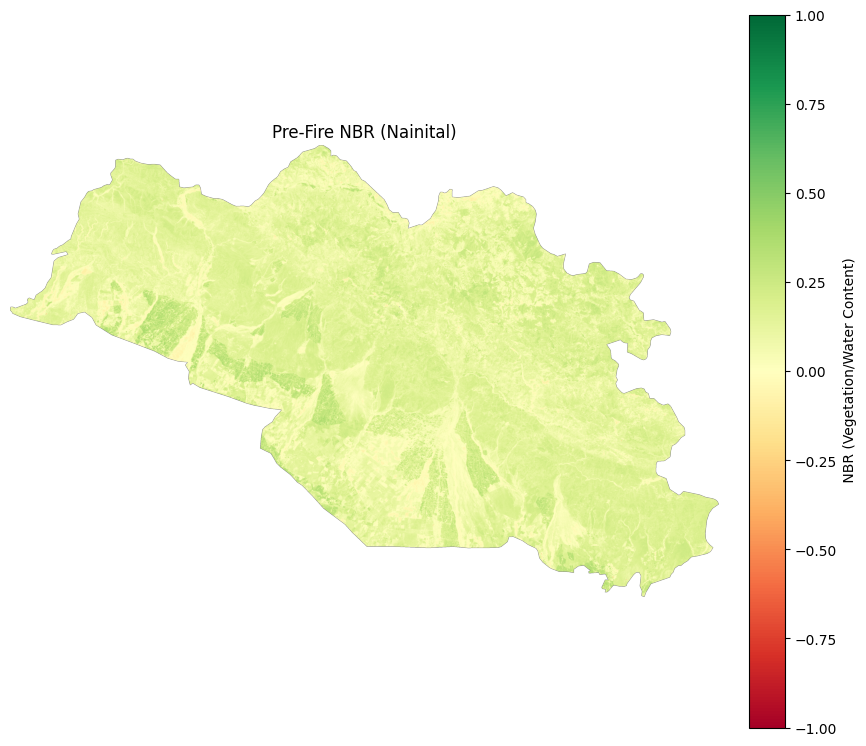

In [23]:
nbr_pre_path = f"{FEATURES_PATH}/nbr_pre.tif"
try:
    with rasterio.open(nbr_pre_path) as src:
        nbr_pre_data = src.read(1)

        # Plot the data
        plt.figure(figsize=(10, 10))
        im = plt.imshow(nbr_pre_data, cmap='RdYlGn', vmin=-1, vmax=1)
        plt.colorbar(im, fraction=0.046, pad=0.04, label=" NBR (Vegetation/Water Content)")
        plt.title("Pre-Fire NBR (Nainital)")
        plt.axis('off')
        plt.show()

except Exception as e:
    print(f"ERROR {e}")

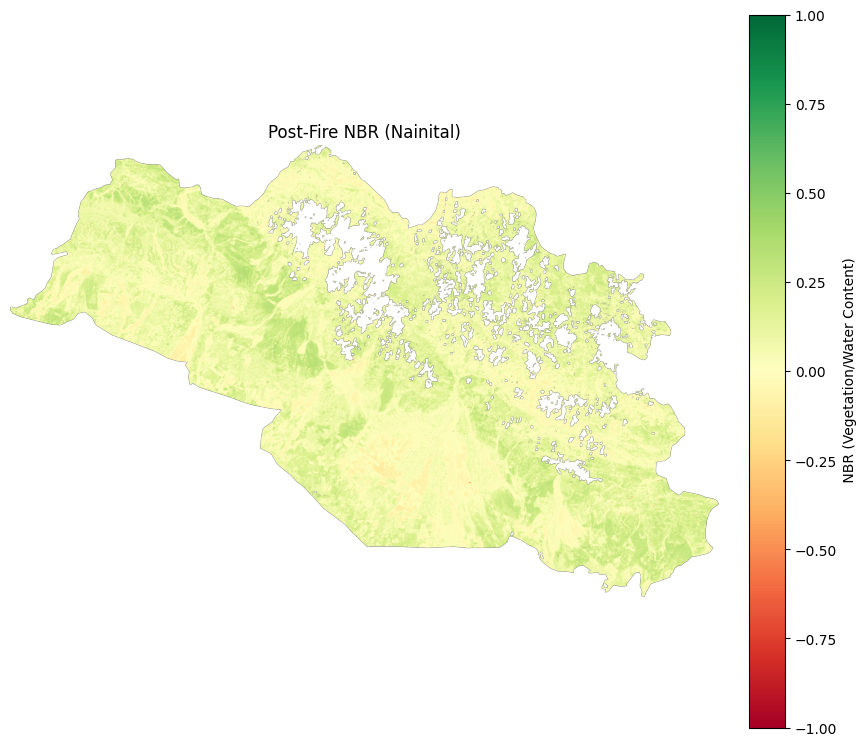

In [24]:
nbr_post_path = f"{FEATURES_PATH}/nbr_post.tif"
try:
    with rasterio.open(nbr_post_path) as src:
        nbr_post_data = src.read(1)

        # Plot the data
        plt.figure(figsize=(10, 10))
        im = plt.imshow(nbr_post_data, cmap='RdYlGn', vmin=-1, vmax=1)
        plt.colorbar(im, fraction=0.046, pad=0.04, label=" NBR (Vegetation/Water Content)")
        plt.title("Post-Fire NBR (Nainital)")
        plt.axis('off')
        plt.show()

except Exception as e:
    print(f"ERROR{e}")

## 3. Calculate dNBR (delta NBR)

This is our "ground truth" or "target" layer. The **delta NBR (or dNBR)** is the difference between the pre-fire and post-fire NBR. This calculation powerfully highlights the areas that were damaged by the fire.

**Formula:** `dNBR = NBR_pre - NBR_post`

In [25]:
nbr_pre_path = f"{FEATURES_PATH}/nbr_pre.tif"
nbr_post_path = f"{FEATURES_PATH}/nbr_post.tif"
try:
    with rasterio.open(nbr_pre_path) as pre_src, rasterio.open(nbr_post_path) as post_src:
        nbr_pre = pre_src.read(1).astype('float32')
        nbr_post = post_src.read(1).astype('float32')

        dNBR = nbr_pre - nbr_post
    save_raster(
        template_raster_path=nbr_pre_path, #
        target_raster_path=f"{FEATURES_PATH}/dNBR.tif",
        data_array=dNBR
    )
except Exception as e:
    print(f"ERROR. {e}")

File exists,: dNBR.tif


## 4. Calculate Environmental Features (Elevation, Slope, Aspect)

Now we will use our clipped Digital Elevation Model (DEM) to create the environmental features. These are critical for predicting *where* a fire is likely to move.
* **Elevation:** Fires behave differently at different altitudes.
* **Slope:** Fires move much faster uphill. This is a very important feature.
* **Aspect:** This is the direction the slope faces (North, South, East, West). South-facing slopes get more sun, are drier, and are often more prone to fire.

We will need a new library, `richdem`, to calculate Slope and Aspect.

In [26]:
# Install the GDAL command-line utilities
!apt-get update -qq > /dev/null
!apt-get install -y gdal-bin > /dev/null


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [27]:
import shutil
dem_filename = "clipped_DEM.tif"
dem_path = f"{PROCESSED_PATH}/{dem_filename}"

elevation_output = f"{FEATURES_PATH}/elevation.tif"
slope_output = f"{FEATURES_PATH}/slope.tif"
aspect_output = f"{FEATURES_PATH}/aspect.tif"

try:
    if not os.path.exists(elevation_output):
        shutil.copyfile(dem_path, elevation_output)
        print("saved: elevation.tif\n")
    else:
        print("File exists elevation.tif")

    if not os.path.exists(slope_output):
        !gdaldem slope "{dem_path}" "{slope_output}" -co COMPRESS=LZW
        if os.path.exists(slope_output):
            print("saved: slope.tif\n")
        else:
            print("ERROR\n")
    else:
        print("File exists slope.tif")

    if not os.path.exists(aspect_output):
        !gdaldem aspect "{dem_path}" "{aspect_output}" -co COMPRESS=LZW

        if os.path.exists(aspect_output):
            print("saved: aspect.tif\n")
        else:
            print("ERROR\n")
    else:
        print("File exists aspect.tif")

except Exception as e:
    print(f"ERROR. {e}")

File exists elevation.tif
File exists slope.tif
File exists aspect.tif
